# TP1a - Génération de variables aléatoires (Première partie)

## Estimation avancée - G3 SDIA

Dans ce TP, on s'intéresse à la génération de variables aléatoires, i.e., la capacité de produire des échantillons finis de variables ou vecteurs aléatoires d'une loi donnée. On suppose que l'on dispose d'un générateur de loi uniforme sur $[0,1]$ (avec Numpy, il est donné par $\texttt{np.random.rand}$). À partir de ce générateur, le but de ce TP sera de générer des échantillons d'autres lois, avec des méthodes simples, notamment la méthode de la *transformée inverse*. Des méthodes plus sophistiquées (acceptation-rejet, échantillonnage d'importance) seront présentées et étudiées à la séance suivante (après les vacances). Ce sera le sujet du TP-1b.

Pour chaque question, justifier la solution puis l'implémenter. Comparer avec la densité théorique à l'aide d'histogrammes ou de *kernel density estimates*.

### Instructions

1. Renommer votre notebook sous la forme `tp1a_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 8 Novembre 2023, 23h59.

### Antonin MOREL
### Benjamin RENOUX

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity

### Partie 1 - Pour s'échauffer : lois uniformes

**Q1**. À partir de $N$ échantillons d'une loi uniforme sur l'intervalle $[0,1]$, comment obtenir $N$ échantillons d'une loi uniforme sur l'intervalle $[a,b]$ ?

---- Votre réponse ici ----

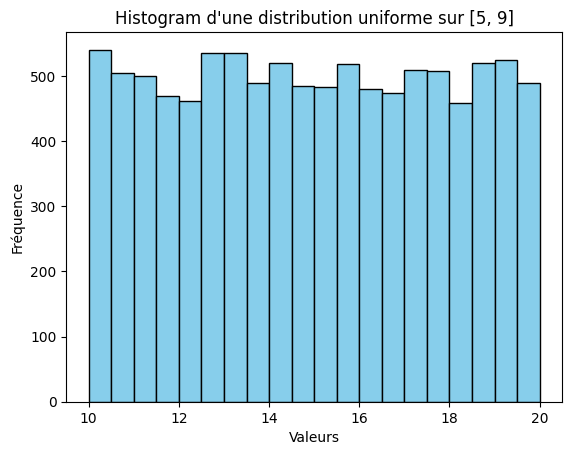

In [12]:
#####

def uniform_01(N):
    return np.random.rand(N)

# On transforme de manière linéaire sur [a, b]
def uniform_ab(a, b, N):
    return a + (b - a) * uniform_01(N)

# Nombre d'échantillons
N = 10000
# Bornes de la transformation
a = 10
b = 20

samples = uniform_ab(a, b, N)
# Plotting the samples
plt.hist(samples, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogramme d\'une distribution uniforme sur [5, 9]')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()

**Q2**. Comment obtenir $N$ échantillons d'une loi uniforme sur le pavé $[a,b] \times [c,d]$ ?

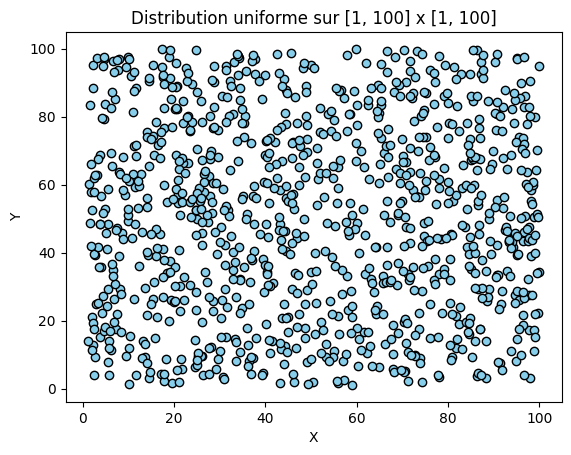

In [15]:
#####
# On génère 2 N-échantillons sur [0,1]
# On transforme linéairement le premier en [a,b] et le deuxième en [c,d]
# On forme les tuples en prenant 1 à 1 les éléments à la ième position des deux échantillon
# L'échantillon produit est dans [a,b]x[c,d]

def uniform_abcd(a,b,c,d,N):
    return np.column_stack( (uniform_ab(a,b,N), uniform_ab(c,d,N)) ) 

N = 1000
samples = uniform_abcd(1,100,1,100,N)
# Plotting the samples in 2D
plt.scatter(samples[:,0], samples[:,1], color='skyblue', edgecolors='black')
plt.title('Distribution uniforme sur [1, 100] x [1, 100]')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

**Q3**. À partir de $N$ échantillons de loi uniforme sur l'intervalle $[0,1]$, comment obtenir $N$ échantillon de loi uniforme discrète sur $\{1, ..., K\}$ ?

---- Votre réponse ici ----

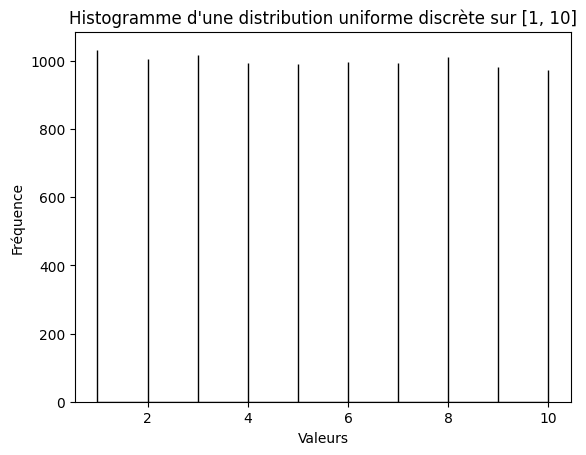

In [30]:
#####
# On effectue le changement pour un N-échantillon vers un intervalle [1,K+1]
# On arrondit chaque échantillon à l'arrondit inférieur
# Si des éléments sont K+1, on les supprime et on tire de nouveaux éléments pour venir compléter jusqu'à avoir N valeurs
# différentes de K+1
# Ce cas à une probabilité nulle d'arriver, mais le jour où il arrive on est pas content
#####

def uniform_discret(N,K):
    uniform_1K = np.floor(uniform_ab(1,K+1,N))
    uniform_1K = uniform_1K[uniform_1K != K+1]

    while (len(uniform_1K) < N):
        uniform_1K = np.concatenate(uniform_1K, np.floor(uniform_ab(1,K+1,N- len(uniform_1K))))
        uniform_1K = uniform_1K[uniform_1K != a]
    
    return uniform_1K.astype(int)

K = 10
N = 10000

samples = uniform_discret(N,K)

plt.hist(samples, bins=int(N), color='skyblue', edgecolor='black')
plt.title(f'Histogramme d\'une distribution uniforme discrète sur [1, {K}]')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()

### Partie 2 - Méthode de la transformée inverse

Soit $X$ une variable aléatoire réelle de fonction de répartition $F$ (rappel : $F$ est une fonction croissante de $\mathbb{R}$ dans $[0,1]$, et "càdlàg", mais pas nécessairement bijective). On définit la **fonction inverse généralisée** $F^{-1}$ de $F$ par :
$$\forall~u \in [0,1], F^{-1}(u) = \inf\{x \in \mathbb{R}, F(x) \geq u\}.$$

Cette fonction conïncide avec l'inverse classique quand $F$ est bijective (attention même si $F$ est continue elle n'est pas nécessairement bijective, il peut y avoir des plateaux).

**Q1**. Montrer la proposition suivante :

Si $U$ suit la loi uniforme sur l'intervalle $[0,1]$, alors la v.a. $F^{-1}(U)$ a pour fonction de répartition $F$ (et donc la même loi que $X$).

Cela donne donc la méthode de la **transformée inverse** ; Si l'on connait explicitement la fonction $F^{-1}$, on peut simuler de n'importe quelle variable aléatoire à partir d'un échantillon de loi uniforme.

Soit $F_X$ la fonction de répartition de X.  
On veut montrer que $F_{F_X^{-1}(U)} = F_X$  
Soient $\Theta_{X}$ le support de $X$ et $x \in \Theta_{X}$, $$F_{F_X^{-1}(U)}(x) = \mathbb{P}(F_X^{-1}(U) \leq x) = \mathbb{P}(U \leq F_X^{-1}(x)) = F_U(F_X^{-1}(x))$$
   
Or, 
* F_X étant une fonction de répartition, $F_X^{-1}(x) \in [0,1]$
* $\forall x \in [0,1], F_U(x) = x$

Donc $$F_U(F_X^{-1}(x)) = F_X^{-1}(x)$$
Donc $$F_{F_X^{-1}(U)} = F_X$$

**Q2**. À l'aide de cette méthode, simuler $N$ échantillons d'une loi exponentielle de paramètre $\lambda$.

Si X suit une loi Exp(lambda)
On cherche d'abord F la fonction de répartition de X.
F(x) = 1 - exp(-lambda * x)

On en déduit F-1(u) = (-1/lambda)* ln(1-u)

En prenant u échantillon d'une loi uniforme, f-1(u) suit une loi exponentielle.

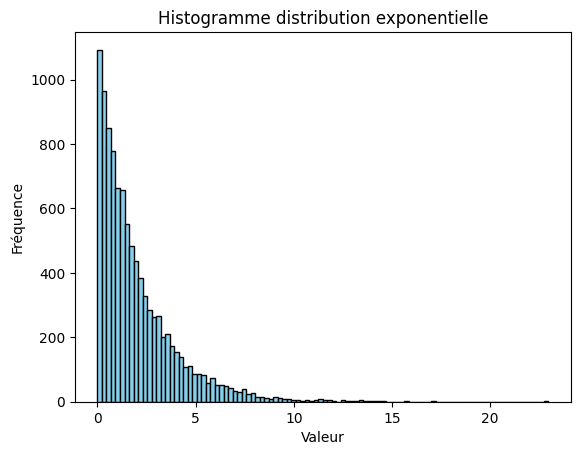

In [34]:
#####
def exp_transfo_inverse(N, lam):

    # On génère des échantillons à partir d'une distribution uniforme
    uniform_01 = np.random.rand(N)
    
    # On applique la méthode de la transformée inverse pour la distribution exponentielle
    exponential_samples = (-1 / lam) * np.log(1 - uniform_01)
    
    return exponential_samples
#####

N = 10000
lam = 0.5

samples = exp_transfo_inverse(N, lam)


plt.hist(samples, bins=100, color='skyblue', edgecolor='black')
plt.title('Histogramme distribution exponentielle')
plt.xlabel('Valeur')
plt.ylabel('Fréquence')
plt.show()

**Q3**. À l'aide de cette méthode, simuler $N$ échantillons d'une loi de Cauchy (standard, i.e. $x_0 = 0, a = 1$).

---- Votre réponse ici ----

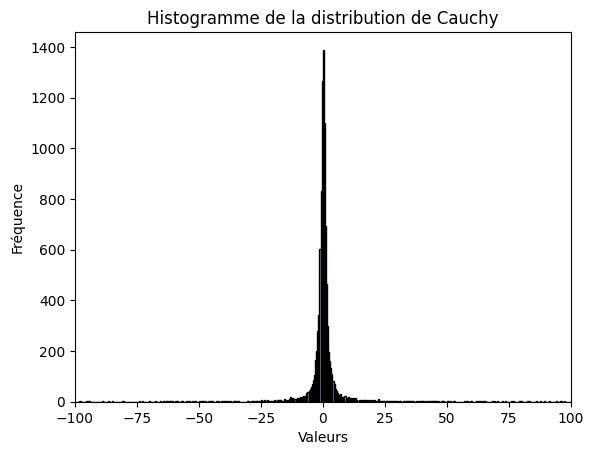

In [42]:
#####
def cauchy_inverse(N):
    uniform_01 = np.random.rand(N)
    ## Fonction de répartition inverse de la loi de cauchy
    cauchy_samples = np.tan(np.pi * (uniform_01 - 0.5))
    return cauchy_samples
#####

N = 10000
samples = cauchy_inverse(N)

plt.hist(samples, bins=10000, color='skyblue', edgecolor='black')
plt.title('Histogramme de la distribution de Cauchy')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.xlim(-100, 100)
plt.show()

**Q4**. Quelles sont les limitations de la méthode de la transformée inverse ?

- Calculs potentiellement très coûteux : 
    - Connaitre la fonction de répartition de la VA que l'on veut sampler
    - Réussir à l'inverser

### Partie 3 - Transformation particulière : Méthode de Box-Müller

**Q1**. Soit $R \sim \text{Exp}(1/2)$ et $\Theta \sim U([0, 2 \pi])$ deux variables aléatoires indépendantes.

Montrer que $X = \sqrt{R} cos(\Theta)$ et $Y = \sqrt{R} sin(\Theta)$ sont deux variables indépendantes de loi $\mathcal{N}(0,1)$.

Cette méthode est connue comme la méthode de Box-Müller (1958), et est l'une des méthodes de référence pour générer des variables aléatoires normales.

Soit $\phi: \mathbb{R}^2 \rightarrow \mathbb{R}$ mesurable positive  

Comme $R$ et $\Theta$ sont indépendantes, on a par le théorème de transfert $$E(\phi(X)) = \int \phi(\sqrt{r}cos(\theta)) * \frac{1}{2} \exp(-\frac{r}{2}) * \frac{1}{2\pi} dr d\theta$$

Puis, par le changement de variable $s^2 = r$
$$E(\phi(X)) = \int \phi(scos(\theta)) * \exp(-\frac{s^2}{2})s * \frac{1}{2\pi} ds d\theta$$

Enfin, on passe en coordonées polaires :
* $x = scos(\theta)$
* $y = ssin(\theta)$
* $\det\begin{vmatrix}
cos(\theta) & -ssin(\theta) \\
sin(\theta) & scos(\theta)
\end{vmatrix} = -s$ donc $dudv = \frac{1}{s}dxdy$

D'où

$$E(\phi(X)) = \int \phi(x) *  \frac{1}{2\pi} \exp(-\frac{x^2+y^2}{2}) dx dy$$

Puis, comme $\int \frac{1}{\sqrt{2\pi}} \exp(-\frac{y^2}{2}) dy = 1$, $$X \sim \mathcal{N}(0,1)$$

Le raisonnement est le même pour Y.

De plus, par le même calcul on montre que
$$E(\phi(X,Y)) = \int \phi(x,y) *  \frac{1}{2\pi} \exp(-\frac{x^2+y^2}{2}) dx dy$$

Donc la densité de $(X,Y)$ est égale au produit des densités donc $X$ et $Y$ sont indépendantes.

**Q2**. En déduire une façon de générer un $N$ échantillons de loi normale $\mathcal{N}(0,1)$ à partir d'échantillons d'une loi uniforme sur l'intervalle $[0,1]$.

In [8]:
#####
### YOUR CODE HERE
#####

**Q3**. À partir de $N$ échantillons de loi $\mathcal{N}(0,1)$, comment obtenir un $N$ échantillons de loi $\mathcal{N}(\mu, \sigma^2)$ ?

---- Votre réponse ici ----

In [9]:
#####
### YOUR CODE HERE
#####

**Q4**. On s'intéresse maintenant à la simulation d'un **vecteur** gaussien en dimension $d$.

Expliquer pourquoi la méthode de Box-Müller permet de simuler des vecteurs de loi $\mathcal{N_d}(\mathbf{0}_d, I_d)$.

Soit $X \sim \mathcal{N_d}(\mathbf{0}_d, I_d)$, $\mathbf{m} \in \mathbb{R}^d$, et $\boldsymbol{\Sigma} \in \mathbb{R}^{d \times d}$ symétrique définie positive. On suppose qu'il existe $\mathbf{L} \in \mathbb{R}^{d \times d}$ tel que $\boldsymbol{\Sigma} = \mathbf{L} \mathbf{L}^{\top}$. À l'aide des propriétés des vecteurs gaussiens, montrer que $Y = m + \mathbf{L}X \sim \mathcal{N_d}(\mathbf{m}, \boldsymbol{\Sigma})$.

---- Votre réponse ici ----

**Q5**. On peut montrer qu'une telle matrice $\mathbf{L}$ existe toujours. C'est la **décomposition de Cholesky** ($\mathbf{L}$ est triangulaire inférieure), qui est fondamentale en statistique et *machine learning*. Elle tire son nom d'André-Louis Cholesky, ingénieur polytechnicien, mort pendant la première guerre mondiale (résultat publié de manière posthume en 1924). À noter que le coût de calcul de cette décomposition est $\mathcal{O}(d^3)$ !

À partir de $N$ échantillons de loi $\mathcal{N_d}(\mathbf{0}_d, I_d)$, générer $N$ échantillons de loi $\mathcal{N_d}(\mathbf{m}, \boldsymbol{\Sigma})$. Prendre $d=2$ et utiliser $\texttt{np.linalg.cholesky}$.

In [10]:
#####
### YOUR CODE HERE
#####